In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%reset -f

In [2]:
import numpy as np
import time
import cv2
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
from skimage import io,color
from skimage.feature import hog
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Part2: Election Outcome Prediction

## 2.1 Direct Prediction by Rich Features

In [3]:
data_sen = loadmat('stat-sen.mat')
data_gov = loadmat('stat-gov.mat')
lms_sen=data_sen['face_landmark'] # (116*160)
vote_sen=data_sen['vote_diff'].ravel()  # (116*1)
lms_gov=data_gov['face_landmark'] # (112*160)
vote_gov=data_gov['vote_diff'].ravel()  # (112*1)

In [4]:
vote_gov.shape

(112,)

In [5]:
def read_images(data_dir, w, h, c):    
    files = os.listdir(data_dir)
    fimages = [os.path.join(data_dir, f) for f in files if f[-3:] == 'jpg']
    images = np.zeros((len(fimages), w, h, c), dtype=int)
    for i, fi in enumerate(fimages):
        images[i, ...] = plt.imread(fi)
    return images

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

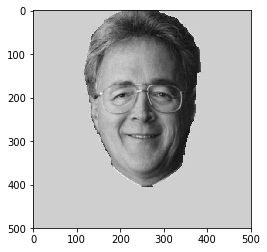

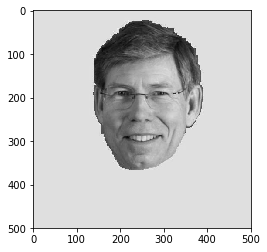

In [6]:
gov_data_dir='img-elec/governor'
sen_data_dir='img-elec/senator'
plt.figure()
img_gov=read_images(gov_data_dir,500,500,3)
img_gov_gray = [ color.rgb2gray(i) for i in img_gov]
plt.imshow(img_gov_gray[0],cmap='gray')
plt.figure()
img_sen=read_images(sen_data_dir,500,500,3)
img_sen_gray = [ color.rgb2gray(i) for i in img_sen]
plt.imshow(img_sen_gray[0],cmap='gray')

ppc=32
hog_gov_images = []
hog_gov_features = []
for image in img_gov_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(2, 2),block_norm= 'L2',visualize=True)
    hog_gov_images.append(hog_image)
    hog_gov_features.append(fd)
hog_gov=np.array(hog_gov_features)
lms_hog_gov=np.concatenate((lms_gov, hog_gov), axis = 1)

hog_sen_images = []
hog_sen_features = []
for image in img_sen_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(2, 2),block_norm= 'L2',visualize=True)
    hog_sen_images.append(hog_image)
    hog_sen_features.append(fd)    
hog_sen=np.array(hog_sen_features)
lms_hog_sen=np.concatenate((lms_sen, hog_sen), axis = 1)

In [62]:
gov_min_max_scaler = MinMaxScaler()
lms_hog_gov_scale = gov_min_max_scaler.fit_transform(lms_hog_gov)
sen_min_max_scaler = MinMaxScaler()
lms_hog_sen_scale = sen_min_max_scaler.fit_transform(lms_hog_sen)

random_state=200
kf = KFold(n_splits=4,shuffle=True,random_state=random_state)

param_grid_gov={"C": np.logspace(-2, 0, 5),
            "gamma": np.logspace(-3, -1, 5),
            "epsilon": np.logspace(-7, -4, 5)}

svr_gov = GridSearchCV(SVR(kernel='rbf'),param_grid_gov ,cv=4)

param_grid_sen={"C": np.logspace(-2, 0, 5),
            "gamma": np.logspace(-3, -2, 5),
            "epsilon": np.logspace(-6, -4, 5)}

svr_sen = GridSearchCV(SVR(kernel='rbf'),param_grid_sen ,cv=4)

In [71]:
train_gov_accuracy=[]
test_gov_accuracy=[]
for train, test in kf.split(lms_hog_gov_scale):
    train_X=lms_hog_gov_scale[train,:]
    test_X=lms_hog_gov_scale[test,:]
    t0 = time.time()
    svr_gov.fit(train_X, vote_gov[train])
    print("done in %0.3fs" % (time.time() - t0))
    print("Best estimator found by grid search:")
    print(svr_gov.best_estimator_)
    train_Y=svr_gov.predict(train_X)
    test_Y=svr_gov.predict(test_X)
    train_gov_accuracy.append(accuracy_score(np.sign(vote_gov[train]), np.sign(train_Y)))
    test_gov_accuracy.append(accuracy_score(np.sign(vote_gov[test]),np.sign(test_Y)))
print("Average accuracies on training data for Governor Election:%0.4f" % (np.mean(np.array(train_gov_accuracy))))
print("Average accuracies on testing data for Governor Election:%0.4f" % (np.mean(np.array(test_gov_accuracy))))

GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.03162, 0.1    , 0.31623, 1.     ]), 'gamma': array([0.001  , 0.00316, 0.01   , 0.03162, 0.1    ]), 'epsilon': array([1.00000e-07, 5.62341e-07, 3.16228e-06, 1.77828e-05, 1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

done in 50.793s
Best estimator found by grid search:
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=3.162277660168379e-06,
  gamma=0.1, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)


GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.03162, 0.1    , 0.31623, 1.     ]), 'gamma': array([0.001  , 0.00316, 0.01   , 0.03162, 0.1    ]), 'epsilon': array([1.00000e-07, 5.62341e-07, 3.16228e-06, 1.77828e-05, 1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

done in 49.097s
Best estimator found by grid search:
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=1e-07, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.03162, 0.1    , 0.31623, 1.     ]), 'gamma': array([0.001  , 0.00316, 0.01   , 0.03162, 0.1    ]), 'epsilon': array([1.00000e-07, 5.62341e-07, 3.16228e-06, 1.77828e-05, 1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

done in 50.870s
Best estimator found by grid search:
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=1e-07, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([0.01   , 0.03162, 0.1    , 0.31623, 1.     ]), 'gamma': array([0.001  , 0.00316, 0.01   , 0.03162, 0.1    ]), 'epsilon': array([1.00000e-07, 5.62341e-07, 3.16228e-06, 1.77828e-05, 1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

done in 56.094s
Best estimator found by grid search:
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=1e-07, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Average accuracies on training data for Governor Election:0.9405
Average accuracies on testing data for Governor Election:0.5089


In [ ]:
train_sen_accuracy=[]
test_sen_accuracy=[]
for train, test in kf.split(lms_hog_gov_scale):
    train_X=lms_hog_sen_scale[train,:]
    test_X=lms_hog_sen_scale[test,:]
    t0 = time.time()
    svr_sen.fit(train_X, vote_sen[train])
    print("done in %0.3fs" % (time.time() - t0))
    print("Best estimator found by grid search:")
    print(svr_sen.best_estimator_)
    train_Y=svr_sen.predict(train_X)
    test_Y=svr_sen.predict(test_X)
    train_sen_accuracy.append(accuracy_score(np.sign(vote_sen[train]), np.sign(train_Y)))
    test_sen_accuracy.append(accuracy_score(np.sign(vote_sen[test]), np.sign(test_Y)))
print("Average accuracies on training data for Senator Election:%0.4f" % (np.mean(np.array(train_sen_accuracy))))
print("Average accuracies on testing data for Senator Election:%0.4f" % (np.mean(np.array(test_sen_accuracy))))

## 2.2 Prediction by Face Social Traits

### Repeat section 1.2 and apply the classifiers later

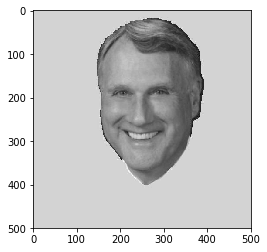

In [7]:
train_anno=loadmat('train-anno.mat')
annotation=train_anno['trait_annotation'] #(491*14)
lms=train_anno['face_landmark'] #(491*160)
img_data_dir='img'
img=read_images(img_data_dir,500,500,3)
img_gray = [ color.rgb2gray(i) for i in img]
plt.imshow(img_gray[0],cmap='gray')
ppc=32
hog_images = []
hog_features = []
for image in img_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(2, 2),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [8]:
#new_anno=np.array(2*(annotation>0)-1)
hog_features=np.array(hog_features)
lms_hog=np.concatenate((lms, hog_features), axis = 1)
new_min_max_scaler = MinMaxScaler()
lms_hog_scale = new_min_max_scaler.fit_transform(lms_hog)
#X_test_minmax = min_max_scaler.transform(X_test)
param_grid={"C": np.logspace(-1, 2, 4),
            "gamma": np.logspace(-4, -1, 4),
            "epsilon": np.logspace(-3, -1, 4)}

svr = GridSearchCV(SVR(kernel='rbf'),param_grid ,cv=8)
SVR=[]
for i in range(annotation.shape[1]):
    svr.fit(lms_hog_scale, annotation[:,i])
    SVR.append(svr.best_estimator_)
    svr_pred=svr.predict(lms_hog_scale)
    print("The best estimator for No.%d facial trait is:" %(i+1))
    print(svr.best_estimator_)
    print("The MSE for No.%d facial trait is:" %(i+1))
    print(mean_squared_error(annotation[:,i], svr_pred))

GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.1 facial trait is:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.1 facial trait is:
0.016963231943461502


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.2 facial trait is:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.2 facial trait is:
0.011585635562414416


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.3 facial trait is:
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.021544346900318832,
  gamma=0.01, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)
The MSE for No.3 facial trait is:
0.0004534618327019297


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.4 facial trait is:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.021544346900318832,
  gamma=0.01, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)
The MSE for No.4 facial trait is:
0.0012384114732186555


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.5 facial trait is:
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.5 facial trait is:
0.008467641098705424


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.6 facial trait is:
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.6 facial trait is:
0.046964477154652


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.7 facial trait is:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.7 facial trait is:
0.04293469480288553


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.8 facial trait is:
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.004641588833612777,
  gamma=0.0001, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)
The MSE for No.8 facial trait is:
0.028412226485563605


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.9 facial trait is:
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.021544346900318832,
  gamma=0.0001, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)
The MSE for No.9 facial trait is:
0.03064556029907713


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.10 facial trait is:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.10 facial trait is:
0.03089748988463232


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.11 facial trait is:
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.11 facial trait is:
0.0332007435398294


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.12 facial trait is:
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.12 facial trait is:
0.04713302996720022


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.13 facial trait is:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.13 facial trait is:
0.008592805713326533


GridSearchCV(cv=8, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. , 100. ]), 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   ]), 'epsilon': array([0.001  , 0.00464, 0.02154, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The best estimator for No.14 facial trait is:
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
The MSE for No.14 facial trait is:
0.046871210847620255


In [9]:
svr_pred=SVR[1].predict(lms_hog_scale)
print(mean_squared_error(annotation[:,1], svr_pred))

0.011585635562414416


In [10]:
lms_hog_gov_scale=new_min_max_scaler.transform(lms_hog_gov)
lms_hog_sen_scale=new_min_max_scaler.transform(lms_hog_sen)
features_gov=np.zeros((112,14))
features_sen=np.zeros((116,14))
for i in range(14):
    features_gov[:,i]=SVR[i].predict(lms_hog_gov_scale)
    features_sen[:,i]=SVR[i].predict(lms_hog_sen_scale)

new_features_gov=np.zeros((56,14))
new_features_sen=np.zeros((58,14))
new_vote_gov=np.zeros((56,1))
new_vote_sen=np.zeros((58,1))
for i in range(56):
    if i<=27:
        new_vote_gov[i]=vote_gov[2*i+1]-vote_gov[2*i]
        new_features_gov[i,:]=features_gov[2*i+1,:]-features_gov[2*i,:]
    else:
        new_vote_gov[i]=vote_gov[2*i]-vote_gov[2*i+1]
        new_features_gov[i,:]=features_gov[2*i,:]-features_gov[2*i+1,:]

for i in range(58):
    if i<=28:
        new_vote_sen[i]=vote_sen[2*i+1]-vote_sen[2*i]
        new_features_sen[i,:]=features_sen[2*i+1,:]-features_sen[2*i,:]
    else:
        new_vote_sen[i]=vote_sen[2*i]-vote_sen[2*i+1]
        new_features_sen[i,:]=features_sen[2*i,:]-features_sen[2*i+1,:]

In [11]:
from scipy.stats.stats import pearsonr  
cor_gov=np.zeros((14,1))
p_gov=np.zeros((14,1))
cor_sen=np.zeros((14,1))
p_sen=np.zeros((14,1))
for i in range(14):
    cor_gov[i]=pearsonr(features_gov[:,i],vote_gov)[0]
    p_gov[i]=pearsonr(features_gov[:,i],vote_gov)[1]
    cor_sen[i]=pearsonr(features_sen[:,i],vote_sen)[0]
    p_sen[i]= pearsonr(features_sen[:,i],vote_sen)[1]

In [12]:
print("The correlation coefficient for Governor Election")
print(cor_gov)
print("The p value for Governor Election")
print(p_gov)
print("The correlation coefficient for Senator Election")
print(cor_sen)
print("The p value for Senator Election")
print(p_sen)

The correlation coefficient for Governor Election
[[-0.08141468]
 [ 0.19553926]
 [-0.05407625]
 [ 0.07236803]
 [ 0.24517417]
 [ 0.18185464]
 [ 0.28606434]
 [-0.05970048]
 [-0.06230226]
 [-0.05930477]
 [ 0.02356926]
 [ 0.22950263]
 [ 0.05749688]
 [ 0.14448011]]
The p value for Governor Election
[[0.39345757]
 [0.03881264]
 [0.57120101]
 [0.44828676]
 [0.00917497]
 [0.05498286]
 [0.00223101]
 [0.53178691]
 [0.5140253 ]
 [0.53451488]
 [0.80516394]
 [0.01492623]
 [0.54706638]
 [0.12854448]]
The correlation coefficient for Senator Election
[[ 0.08843666]
 [-0.10826845]
 [-0.00756558]
 [-0.02511064]
 [-0.04288969]
 [-0.09914698]
 [ 0.01328372]
 [ 0.04992807]
 [-0.02986343]
 [-0.01873965]
 [-0.06584657]
 [-0.09961686]
 [ 0.05502657]
 [-0.15672032]]
The p value for Senator Election
[[0.34515529]
 [0.24732843]
 [0.93575805]
 [0.7890356 ]
 [0.6475676 ]
 [0.2896486 ]
 [0.88745371]
 [0.59455261]
 [0.75031296]
 [0.84174343]
 [0.48250977]
 [0.28735761]
 [0.55741811]
 [0.09294793]]


In [24]:
from scipy.stats.stats import pearsonr  
new_cor_gov=np.zeros((14,1))
new_p_gov=np.zeros((14,1))
new_cor_sen=np.zeros((14,1))
new_p_sen=np.zeros((14,1))
for i in range(14):
    new_cor_gov[i]=pearsonr(new_features_gov[:,i],new_vote_gov.ravel())[0]
    new_p_gov[i]=pearsonr(new_features_gov[:,i],new_vote_gov.ravel())[1]
    new_cor_sen[i]=pearsonr(new_features_sen[:,i],new_vote_sen.ravel())[0]
    new_p_sen[i]= pearsonr(new_features_sen[:,i],new_vote_sen.ravel())[1]
print("The correlation coefficient for Governor Election")
print(new_cor_gov)
print("The p value for Governor Election")
print(new_p_gov)
print("The correlation coefficient for Senator Election")
print(new_cor_sen)
print("The p value for Senator Election")
print(new_p_sen)

The correlation coefficient for Governor Election
[[-0.12329236]
 [ 0.29470269]
 [-0.05420582]
 [ 0.09056947]
 [ 0.31299318]
 [ 0.22330287]
 [ 0.36676446]
 [-0.10462804]
 [-0.07571743]
 [-0.08585063]
 [ 0.02300629]
 [ 0.30871237]
 [ 0.07940867]
 [ 0.22088518]]
The p value for Governor Election
[[0.36531356]
 [0.02746586]
 [0.69152808]
 [0.50679288]
 [0.0188366 ]
 [0.09806274]
 [0.00543057]
 [0.44283477]
 [0.57914444]
 [0.5292702 ]
 [0.86634531]
 [0.0206159 ]
 [0.56073022]
 [0.1018503 ]]
The correlation coefficient for Senator Election
[[ 0.11533581]
 [-0.14425101]
 [-0.01091932]
 [-0.03107244]
 [-0.05676312]
 [-0.13612706]
 [ 0.0234882 ]
 [ 0.06938769]
 [-0.04632333]
 [-0.0287905 ]
 [-0.08596703]
 [-0.13216312]
 [ 0.07412991]
 [-0.2189128 ]]
The p value for Senator Election
[[0.3886146 ]
 [0.27999499]
 [0.93516268]
 [0.81689133]
 [0.67213036]
 [0.30825168]
 [0.86107108]
 [0.60476396]
 [0.72987359]
 [0.83013119]
 [0.52110514]
 [0.32268257]
 [0.58024372]
 [0.09874049]]


In [23]:
pearsonr(new_features_gov[:,i],new_vote_gov.ravel())

(-0.12329235871629285, 0.36531356327896414)

In [30]:
random_state=200
kf = KFold(n_splits=10,shuffle=True,random_state=random_state)

param_grid_svc={"C": np.logspace(-2, 4, 10),"gamma": np.logspace(-4, -1, 10)}
clf_gov = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),param_grid_svc, cv=10)
clf_sen = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),param_grid_svc, cv=10)

new_vote_gov=np.array(2*(new_vote_gov>0)-1).ravel()
new_vote_sen=np.array(2*(new_vote_sen>0)-1).ravel()

new_train_gov_accuracy=[]
new_test_gov_accuracy=[]
for train, test in kf.split(new_features_gov):
    train_X=new_features_gov[train,:]
    test_X=new_features_gov[test,:]
    t0 = time.time()
    clf_gov.fit(train_X, new_vote_gov[train])
    print("Best estimator found by grid search:")
    print(clf_gov.best_estimator_)
    train_Y=clf_gov.predict(train_X)
    test_Y=clf_gov.predict(test_X)
    new_train_gov_accuracy.append(accuracy_score(new_vote_gov[train], train_Y))
    new_test_gov_accuracy.append(accuracy_score(new_vote_gov[test],test_Y))


new_train_sen_accuracy=[]
new_test_sen_accuracy=[]
for train, test in kf.split(new_features_sen):
    train_X=new_features_sen[train,:]
    test_X=new_features_sen[test,:]
    t0 = time.time()
    clf_sen.fit(train_X, new_vote_sen[train])
    print("Best estimator found by grid search:")
    print(clf_sen.best_estimator_)
    train_Y=clf_sen.predict(train_X)
    test_Y=clf_sen.predict(test_X)
    new_train_sen_accuracy.append(accuracy_score(new_vote_sen[train], train_Y))
    new_test_sen_accuracy.append(accuracy_score(new_vote_sen[test],test_Y))
    
print("Average accuracies on training data for Governor Election:%0.4f" % (np.mean(np.array(new_train_gov_accuracy))))
print("Average accuracies on testing data for Governor Election:%0.4f" % (np.mean(np.array(new_test_gov_accuracy))))
print("Average accuracies on training data for Senator Election:%0.4f" % (np.mean(np.array(new_train_sen_accuracy))))
print("Average accuracies on testing data for senator Election:%0.4f" % (np.mean(np.array(new_test_sen_accuracy))))

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=464.1588833612773, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.002154434690031882,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.002154434690031882,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=21.54434690031882, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.046415888336127774,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=21.54434690031882, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=21.54434690031882, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.046415888336127774,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=464.1588833612773, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.021544346900318822,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=21.54434690031882, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.021544346900318822,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=21.54434690031882, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.046415888336127774,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=21.54434690031882, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=2154.4346900318824, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=2154.4346900318824, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=2154.4346900318824, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.002154434690031882,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.021544346900318822,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=464.1588833612773, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.046415888336127774,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-02, 4.64159e-02, 2.15443e-01, 1.00000e+00, 4.64159e+00,
       2.15443e+01, 1.00000e+02, 4.64159e+02, 2.15443e+03, 1.00000e+04]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best estimator found by grid search:
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.046415888336127774,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Average accuracies on training data for Governor Election:0.7183
Average accuracies on testing data for Governor Election:0.5867
Average accuracies on training data for Senator Election:0.8600
Average accuracies on testing data for senator Election:0.4267
